## MNIST CNN

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

# MNIST DataSet

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')

In [8]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/9/3884.png')

In [0]:
defaults.cmap='binary'

In [10]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

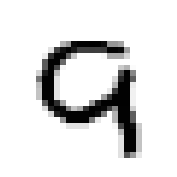

In [11]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [13]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [14]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/6')]

In [0]:
ll = sd.label_from_folder()

In [16]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

9 torch.Size([1, 28, 28])


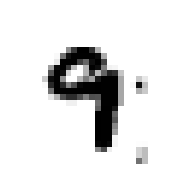

In [18]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

9


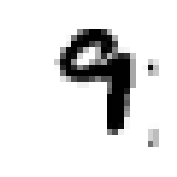

In [24]:
x.show()
print(y)

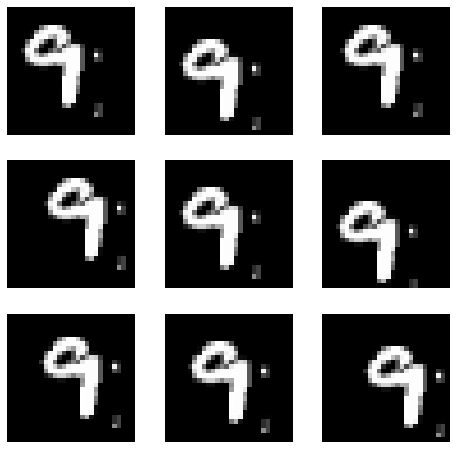

In [25]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [26]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

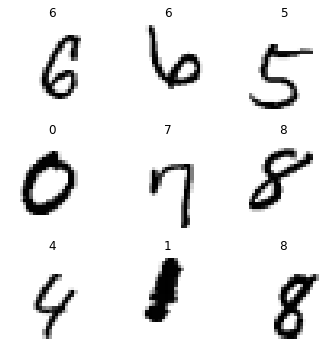

In [27]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

# Conv2d

## This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 
## If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

# ReLU
## 0보다 작은 값이 나온 경우 0을 반환하고, 0보다 큰 값이 나온 경우 그 값을 그대로 반환하는 함수

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [31]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [32]:
xb = xb.cuda()

## 다음과 같은 RuntimeError가 발생합니다.

RuntimeError: ignored

In [33]:
model(xb).shape

torch.Size([128, 10])

In [34]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


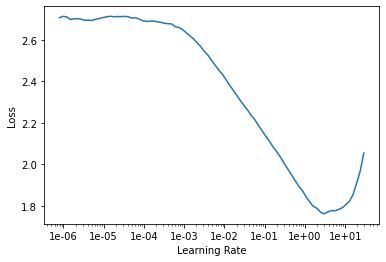

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.222747,0.544702,0.825600,00:37
1,0.128783,0.282049,0.909600,00:36
2,0.078232,0.036394,0.988200,00:36


### Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

# conv_layer
## 합성곱 계층으로 conv2d() 함수에 정의된 선형 합성곱에 편향값을 더한 후 비선형 함수인 ReLU를 적용한다.

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

# CrossEntropyLoss
## 다중분류를 위한 대표적인 손실함수

In [40]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.240305,0.156111,0.950400,00:36
1,0.184908,0.237586,0.927800,00:37
2,0.166571,0.131377,0.960100,00:37
3,0.140517,0.195404,0.936100,00:38
4,0.124816,0.161370,0.950000,00:37
5,0.104747,0.096349,0.970800,00:37
6,0.080339,0.061040,0.978900,00:37
7,0.064303,0.039641,0.986600,00:36
8,0.047843,0.029855,0.989900,00:37
9,0.045137,0.028819,0.989900,00:37


### Resnet-ish

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
help(res_block)

# res_block
## Resnet block of nf features. conv_kwargs are passed to conv_layer.

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


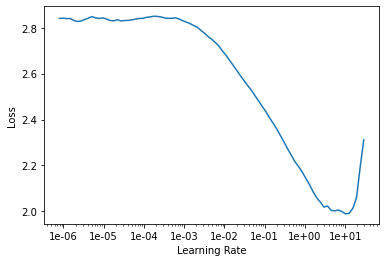

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.216775,0.129448,0.963800,00:53
1,0.140731,0.103154,0.965800,00:53
2,0.102219,0.096704,0.969100,00:53
3,0.080664,0.064158,0.979700,00:53
4,0.075087,0.078727,0.975000,00:54
5,0.066923,0.042954,0.986300,00:54
6,0.050913,0.169682,0.945100,00:53
7,0.040024,0.027039,0.991900,00:54
8,0.030549,0.027477,0.992100,00:54
9,0.024930,0.019050,0.993700,00:56


In [41]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
___________________________________________________

## fin